In [2]:
import numpy as np
import time
import random
import pylab
from hrr import *
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# Number of training cycles
episodes = 10000

# Hrr parameters
hrr_length = 2048
normalized = True

# How many steps to take before quiting
steps_till_quit = 20

signals = ["Red", "Blue"]
goals = [[2, 6]]

# Maze parameters
size_of_maze = 15
non_obs_task_switch_rate = 20
num_non_obs_tasks = len(goals)
num_obs_tasks = len(signals)

# goals = random.sample(range(size_of_maze), num_obs_tasks)

# Arguments for neural network
input_size = hrr_length
output_size = 1
discount = 0.9
alpha = 0.2

# Reward for temporal difference learning
reward_bad = 0
reward_good = 1

# Expolration rate
e_soft = 0.0001

# Threshold for non observable task switching
threshold = -0.2

# Print frequency
p_freq = 1000
p_num = 0

calc_for = 1000
calc_opt_after = episodes - calc_for

# Eligibility trace
eligibility = np.zeros(hrr_length)

# Eligibility trace rate
eli_lambda = 0.01

# atr = np.random.randint(0, num_non_obs_tasks + 1)
atr = 0
wm = "I"

# Neural network
weights = hrr(hrr_length, normalized)
bias = 1

debug = False
opt_calc = False

opt_count = 0
rand_on = 1

In [4]:
def get_moves(state, size_of_maze):
    if(state == 0):
        return size_of_maze - 1, 1
    elif(state == size_of_maze - 1):
        return size_of_maze - 2, 0
    else:
        return state - 1, state + 1

In [7]:
ltm = LTM(hrr_length, normalized)

In [8]:
ltm.print()

I [1. 0. 0. ... 0. 0. 0.]


In [9]:
def move_policy(goal, moves, wms, signals, atr, rand_on):
    
    val = -9999
    temp = -9999
    
    if debug:
        print(moves, wms, signals, atr[0])
        
    for move in moves:
        for wm in list(dict.fromkeys(wms + ["I"])):
            for signal in list(dict.fromkeys(signals + ["I"])):
                if move == goal:
                    encode_str = build_hrr_string(wm, signal, str(move) + "*rewardTkn", atr[0])
                else:
                    encode_str = build_hrr_string(wm, signal, move, atr[0])
                temp = np.dot(weights, ltm.encode(encode_str)) + bias
                if debug:
                    if signal != "I":
                        print("Move:", move, "WM:", wm, "Signal", signal + "In", "ATR:", atr[0], "Value:", temp)
                    else:
                        print("Move:", move, "WM:", wm, "Signal", signal, "ATR:", atr[0], "Value:", temp)
                if temp > val:
                    val = temp
                    s_move = move
                    if signal != "I":
                        s_wm = signal + "In"
                    elif wm != "I":
                        s_wm = wm
                    else:
                        s_wm = "I"
    
    # Random move
    if((np.random.random_sample() < e_soft) and (rand_on == 1)):
        print("Random move")
        return np.random.choice(moves), random.choice(wms), atr[0]

    s_atr = atr[0]
    return s_move, s_wm, s_atr

def context_policy(atr):
    return (atr + 1)%num_non_obs_tasks

def build_hrr_string(wm, signal, state, atr):
    if wm == "I" and signal == "I":
        return "State:" + str(state) + "*" + "Atr:" + str(atr)
    elif wm == "I":
        return "Signal:" + str(signal) + "*" + "State:" + str(state) + "*" + "Atr:" + str(atr)
    elif signal == "I":
        return "WM:" + str(wm) + "*" + "State:" + str(state) + "*" + "Atr:" + str(atr)
    else:
        return "WM:" + str(wm) + "*" + "Signal:" + str(signal) + "*" + "State:" + str(state) + "*" + "Atr:" + str(atr)
    
def get_opt_steps(start, goal, size_of_maze):
    opt = abs(goal - start)
    if opt > size_of_maze / 2:
        opt = size_of_maze - opt
    return opt

def logmod(x):
    return np.sign(x)*np.log(abs(x)+1)

In [10]:
t0 = time.time()
non_obs = 0
current_atr = 0

opt = 0
taken = 0

for x in range(episodes):
    
    if x > episodes - (p_num + 1):
        debug = True
    
    # Starting state
    current_state = random.randint(0, size_of_maze - 1)
    start = current_state
        
    
    # Signal for the maze run
    
    # Maze progresses
    #non_obs, goal = maze.step_maze(signals.index(signal))

    if x%non_obs_task_switch_rate == 0:
        non_obs = (non_obs+1)%num_non_obs_tasks
        
    current_signal = np.random.choice(signals)
    goal = goals[non_obs][signals.index(current_signal)]
        
    if debug:
        print(current_signal, goal)
    
    # Reset trace
    eligibility *= 0.0
    
    current_wm = "I"
    
    y = 0
    
    steps = 0
    total_steps = 0
    taken = 0
    opt = get_opt_steps(start, goal, size_of_maze)
    
    if debug:
        print("Expected: Goal: " + str(goal) + " Signal: " + str(current_signal) + " Non_Observable: " + str(non_obs))
    
    for y in range(steps_till_quit):
        
        # Goal reached
        if (current_state == goal):
            # Get temporal difference error and update weights of neural network
            encode_str = build_hrr_string(current_wm, current_signal, str(current_state) + "*rewardTkn", current_atr)
            goal_hrr = ltm.encode(encode_str)
            goal_value = np.dot(weights, goal_hrr) + bias            
            
            if debug:
                print("In Goal: State Value: " + str(goal_value) + " WM: " + str(current_wm) + " Atr: " + str(current_atr) + "\n")
            
            error = reward_good - goal_value
            eligibility *= eli_lambda
            eligibility = eligibility + goal_hrr
            weights = np.add(weights, (alpha * logmod(error) * eligibility))
            
            break
        
        # Store info about previous state      
        previous_wm = current_wm
        previous_signal = current_signal
        previous_state = current_state
        previous_atr = current_atr
        
        if debug:
            print("Previous WM:", previous_wm, "Signal:", previous_signal, "State", previous_state, "ATR:", previous_atr)
        
        encode_str = build_hrr_string(previous_wm, previous_signal, previous_state, previous_atr)
        previous_state_hrr = ltm.encode(encode_str)
        previous_value = np.dot(weights, previous_state_hrr) + bias
              
        if debug:
            print("Started with: State: " + str(previous_state) + " State Value: " + str(previous_value) + " WM: " + str(previous_wm) + " Atr: " + str(previous_atr))
    
        current_signal = "I"
        left, right = get_moves(previous_state, size_of_maze)
        if previous_signal != "I":
            previous_signal += "In"
            
        move, wm, atr = move_policy(goal, [left, right], [previous_wm, previous_signal], [current_signal], [previous_atr], rand_on)
        total_steps += 1
        
        if opt_calc:
            taken += 1
            
        # Make the move
        current = move
        
        current_wm = wm
        current_state = current
        current_atr = atr
        
        if debug:
            print("Current WM:", current_wm, "Signal:", current_signal, "State", current_state, "ATR:", current_atr)
        
        if current_state == goal:
            encode_str = build_hrr_string(current_wm, current_signal, str(current_state) + "*rewardTkn", current_atr)     
            if debug:
                print("In Goal: State Value: " + str(goal_value) + " WM: " + str(current_wm) + " Atr: " + str(current_atr) + "\n")
        else:
            encode_str = build_hrr_string(current_wm, current_signal, current_state, current_atr)

        current_state_hrr = ltm.encode(encode_str)
        current_value = np.dot(weights, current_state_hrr) + bias
        
        if debug:
            print("Moved: State: " + str(current_state) + " State Value: " + str(current_value) + " WM: " + str(current_wm) + " Atr: " + str(current_atr))
        
        # Weight update for goal not found
        error = (reward_bad + discount * current_value) - previous_value
        if debug:
            print("Error:", error)
        eligibility *= eli_lambda
        eligibility = eligibility + previous_state_hrr
        if error < threshold:
                if debug:
                    print(error)
                current_atr = context_policy(current_atr)
                weights = np.add(weights, (alpha * logmod(error) * eligibility))
                eligibility *= 0.0
                if opt_calc:
                    taken = 0
                    start = current_state
                    opt = get_opt_steps(start, goal, size_of_maze)
                total_steps = 0
                if debug:
                    print("Error from switch:", error)
                    print("Atr after policy: " + str(current_atr))  
        weights = np.add(weights, (alpha * logmod(error) * eligibility))
        
        if debug:
            print()
            
    if opt_calc:
        if taken == opt:
            opt_count += 1
            
    if (x + 2) > calc_opt_after:
        rand_on  = 0
        opt_calc = True
        
    if debug:
        print("Start:", start, "End:", goal, "Opt_steps:", opt, "Total steps taken:", total_steps)

    if debug and y == steps_till_quit - 1:
        print("Fail\n")
        
    if debug:
        input("Press Enter to continue...")
      
    if((x+1)%p_freq == 0):
        print("Episode" , x+1, "done")

print(opt_count, opt_count/calc_for)

Episode 1000 done
Episode 2000 done
Random move
Episode 3000 done
Episode 4000 done
Episode 5000 done
Random move
Episode 6000 done
Episode 7000 done
Episode 8000 done
Episode 9000 done
Episode 10000 done
1000 1.0


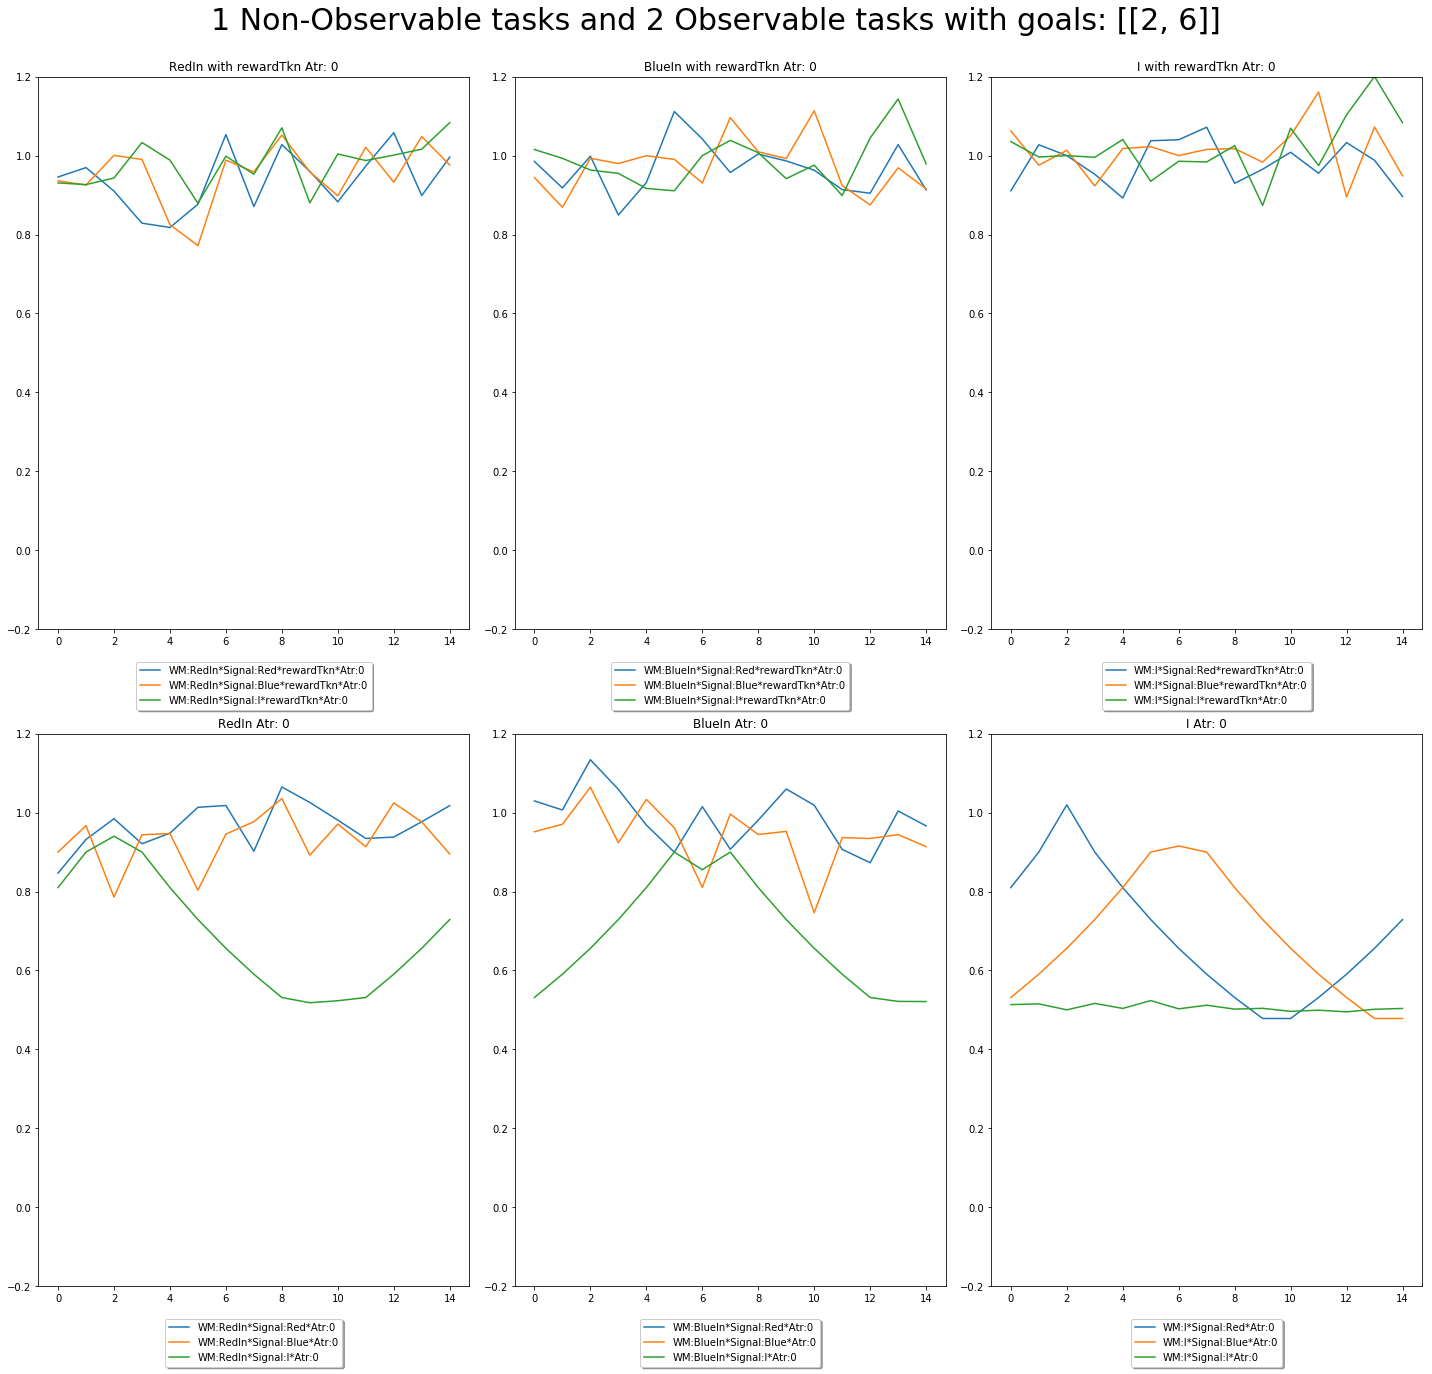

In [11]:
fig, axes = plt.subplots(nrows=num_non_obs_tasks * 2, ncols=num_obs_tasks+1)
fig.set_figwidth(20)
fig.set_figheight(20)

for x in range(num_non_obs_tasks):
    
    x_ind = x * 2
    
    y_for_rwd = 0
    y_for_no_rwd = 0
    
    for wm in list(dict.fromkeys([signal + "In" if signal != "I" else signal for signal in signals] + ["I"])):
        position = np.arange(size_of_maze)
        value = np.zeros(size_of_maze)
        for signal in signals + ["I"]:
            lab = "WM:" + wm + "*Signal:" + signal + "*rewardTkn*Atr:" + str(x)
            for state in range(size_of_maze):
                encode_str = build_hrr_string(wm, signal, str(state) + "*rewardTkn", x)
                value[state] = np.dot(weights, ltm.encode(encode_str)) + bias
            axes[x_ind,y_for_rwd].title.set_text(wm + " with rewardTkn " + "Atr: " + str(x))
            axes[x_ind,y_for_rwd].set_ylim([-0.2, 1.2])
            axes[x_ind,y_for_rwd].plot(position, value, label=lab)
            
            axes[x_ind,y_for_rwd].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                  fancybox=True, shadow=True, ncol=1, prop={'size': 10})
        y_for_rwd += 1
        
        y = x + 1
        value = np.zeros(size_of_maze)
        for signal in list(dict.fromkeys(signals + ["I"])):
            lab = "WM:" + wm + "*Signal:" + signal + "*Atr:" + str(x)
            for state in range(size_of_maze):
                encode_str = build_hrr_string(wm, signal, str(state), x)
                value[state] = np.dot(weights, ltm.encode(encode_str)) + bias
            axes[x_ind+1,y_for_no_rwd].title.set_text(wm + " Atr: " + str(x))
            axes[x_ind+1,y_for_no_rwd].set_ylim([-0.2, 1.2])
            axes[x_ind+1,y_for_no_rwd].plot(position, value, label=lab)
            axes[x_ind+1,y_for_no_rwd].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                  fancybox=True, shadow=True, ncol=1, prop={'size': 10})
        y_for_no_rwd += 1

plt.suptitle(str(len(goals)) + " Non-Observable tasks and " + str(len(signals)) + " Observable tasks with goals: "+ str(goals), fontsize=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("HRR:" + str(hrr_length) + "_Discount:" + str(discount) + "_Alpha:" + str(alpha) + "_Threshold:" + str(threshold) + "_Lambda:" + str(eli_lambda) + '.png')
plt.show()
t1 = time.time()

In [ ]:
total = t1-t0
print(total / 60)

In [ ]:
ltm.print()

In [ ]:
ltm.clean()
del ltm